In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

import plotly.io as pio
import seaborn as sns
from matplotlib.patches import Patch
import itertools
import random
from scipy.stats import pointbiserialr, pearsonr

import glob

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score

import re
import ast

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "STIXGeneral"],
    "pdf.fonttype": 42, "ps.fonttype": 42, "svg.fonttype": "none",
})



pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format


pio.templates

pio.templates.default = 'plotly_white'

# Load Sample and compute Inter Annotator Agreement

In [8]:
df_annot1 = pd.read_excel('../data/eval_annotations/annotator_1.xlsx', converters={'Image': str})
print('Number of annotations annotator 1: ' + str(len(df_annot1)))

df_annot1.rename(columns={"Is the subject present in the image?": "subject_present", 
                        "Is the image correct for the given prompt (applying the required temporal knowledge)?": "temporal",
                        "Is the image without any visual generation errors? ": "img_correct",
                        }, inplace=True)

df_annot2 = pd.read_excel('../data/eval_annotations/annotator_2.xlsx', converters={'Image': str})
print('Number of annotations annotator 2: ' + str(len(df_annot2)))

df_annot2.rename(columns={"Is the subject present in the image?": "subject_present", 
                        "Is the image correct for the given prompt (applying the required temporal knowledge)?": "temporal",
                        "Is the image without any visual generation errors? ": "img_correct",
                        }, inplace=True)




Number of annotations annotator 1: 500
Number of annotations annotator 2: 500


In [9]:
merged = pd.merge(df_annot1[['model', 'prompt','subject_present',
       'img_correct', 'temporal', 'category', 'index']], df_annot2[['model', 'prompt','subject_present',
       'img_correct', 'temporal', 'category', 'index']], on=['prompt', 'model', 'category', 'index'], how='inner', suffixes=('_annot1', '_annot2'))
print(len(merged))
print(len(merged.dropna()))

500
500


## Analyze Inter Annotator Agreement

In [4]:
merged = merged.dropna()

# Compute Cohen's Kappa
print("Overall")
kappa = cohen_kappa_score(merged['subject_present_annot2'].tolist(), merged['subject_present_annot1'].tolist())
print("Cohen's Kappa Subject:", kappa)
kappa = cohen_kappa_score(merged['img_correct_annot2'].tolist(), merged['img_correct_annot1'].tolist())
print("Cohen's Kappa Image Correct:", kappa)
kappa = cohen_kappa_score(merged['temporal_annot2'].tolist(), merged['temporal_annot1'].tolist())
print("Cohen's Kappa Temporal:", kappa)
print()

for category in merged.category.unique():
    print(category)
    subset = merged[merged['category'] == category].copy()
    kappa = cohen_kappa_score(subset['subject_present_annot2'].tolist(), subset['subject_present_annot1'].tolist())
    print("Cohen's Kappa Subject:", kappa)
    kappa = cohen_kappa_score(subset['img_correct_annot2'].tolist(), subset['img_correct_annot1'].tolist())
    print("Cohen's Kappa Image Correct:", kappa)
    kappa = cohen_kappa_score(subset['temporal_annot2'].tolist(), subset['temporal_annot1'].tolist())
    print("Cohen's Kappa Temporal:", kappa)
    print()

Overall
Cohen's Kappa Subject: 0.8970224785218313
Cohen's Kappa Image Correct: 0.5016362941674835
Cohen's Kappa Temporal: 0.9502487562189055

Time
Cohen's Kappa Subject: 1.0
Cohen's Kappa Image Correct: 0.8160261651676206
Cohen's Kappa Temporal: 0.9122422114962703

Animals
Cohen's Kappa Subject: 1.0
Cohen's Kappa Image Correct: 0.55078125
Cohen's Kappa Temporal: 0.9188640973630832

Artworks
Cohen's Kappa Subject: 1.0
Cohen's Kappa Image Correct: 0.30795847750865046
Cohen's Kappa Temporal: 0.9191919191919192

Buildings
Cohen's Kappa Subject: 0.7625643055005936
Cohen's Kappa Image Correct: 0.2801047120418849
Cohen's Kappa Temporal: 1.0

Maps
Cohen's Kappa Subject: 0.9053926206244087
Cohen's Kappa Image Correct: 0.24124513618677046
Cohen's Kappa Temporal: 1.0



## Annotator Disagreement

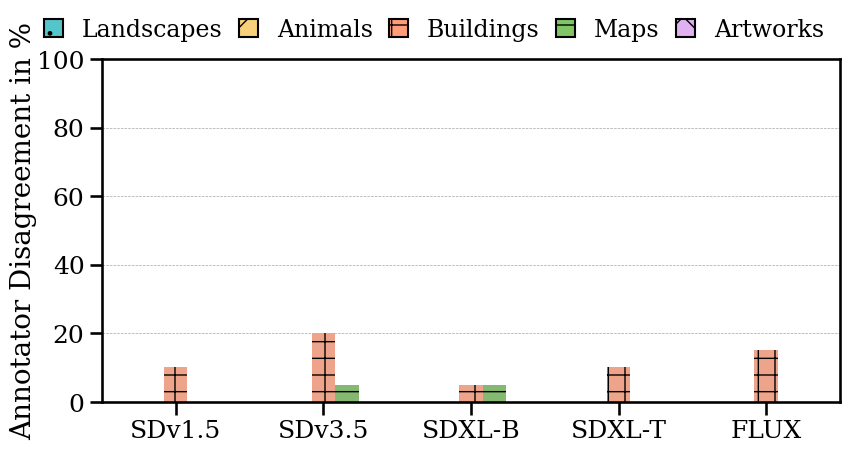

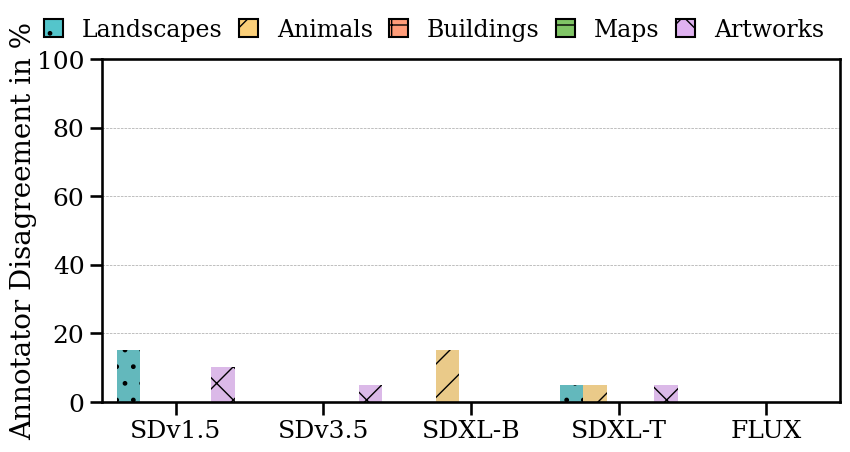

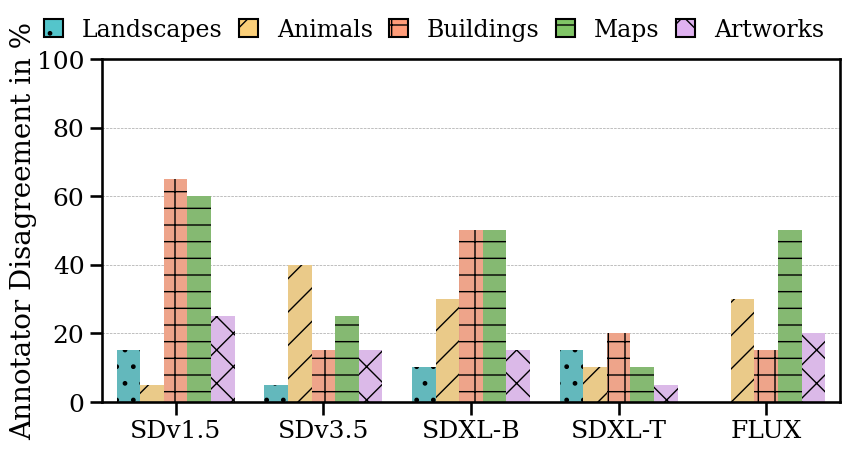

In [11]:
colorList = ['#54C5CB', '#FACF79','#FF9C79', "#80C566" ,"#DFB1F0"]

model_dict = {'sdv15': 'SDv1.5',
              'stable-diffusion-3-5': 'SDv3.5', 
              'sdxlbase': 'SDXL-B',
              'sdxlturbo': 'SDXL-T',
              'blackforest': 'FLUX', }

task_dict = {'subject_present': 'Subject Correct',
            'temporal': 'Temporal Knowledge Correct', 
            'img_correct': 'Image Quality Correct'}

category_dict = {'Time': 'Landscapes',
                'Animals': 'Animals',
                'Buildings': 'Buildings',
                'Maps': 'Maps',
                'Artworks': 'Artworks',
                 }


for topic in ['subject_present', 'temporal', 'img_correct']:
    if type(merged[f'{topic}_annot1'][0]) == str:
        merged[f'{topic}_annot1'] = np.where(merged[f'{topic}_annot1']=='yes', 1, 0)
    if type(merged[f'{topic}_annot2'][0]) == str:
        merged[f'{topic}_annot2'] = np.where(merged[f'{topic}_annot2']=='yes', 1, 0)

    merged['agree'] = np.where(merged[f'{topic}_annot2'] != merged[f'{topic}_annot1'], 1, 0)

        
    group = merged.groupby(['model', 'category'])[f'agree'].agg(['sum', 'count']).reset_index()
    group['percentage_correct'] = (group['sum'] / group['count']) * 100
    group['category'] = group['category'].replace(category_dict)
    group['category'] = pd.Categorical(group['category'], category_dict.values())
    group['model'] = group['model'].replace(model_dict)
    group['model'] = pd.Categorical(group['model'], model_dict.values())
    group = group.sort_values(by=['category','model'])

    categories = list(category_dict.values())
    models = list(model_dict.values())
    palette = {cat: colorList[i % len(colorList)] for i, cat in enumerate(categories)}

    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(9, 5)) 

    sns.barplot(
        data=group,
        x="model", y="percentage_correct",
        hue="category",
        palette=palette,
        dodge=True,
        errorbar=None,
        ax=ax
    )

    num_categories = len(group['category'].unique())
    hatches = itertools.cycle([".", "/", "+", "-", "x"])
    for i, bar in enumerate(ax.patches):
        if i % num_categories == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)


    ax.set_ylim(0, 100)
    ax.set_ylabel("Annotator Disagreement in %", fontsize=20, labelpad=0)
    ax.set_xlabel(None)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7, color="grey")
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    hatches = [".", "/", "+", "-", "x"]
    legend_handles = [
        Patch(facecolor=palette[c], hatch=hatches[i], edgecolor="black",  label=c)
        for i, c in enumerate(categories)
    ]
    leg = ax.legend(
        handles=legend_handles, title=None,
        loc="upper center", bbox_to_anchor=(0.45, 1.18),
        ncol=min(5, len(categories)), frameon=False,
        fontsize=17,
        handlelength=0.8,     
        handleheight=0.8,   
        columnspacing=0.7,
    )

    plt.tight_layout()
    fig.subplots_adjust(top=0.82)  
    fig.savefig(f"../img/annotator_disagreement_{topic}.pdf", bbox_inches="tight")
    plt.show()


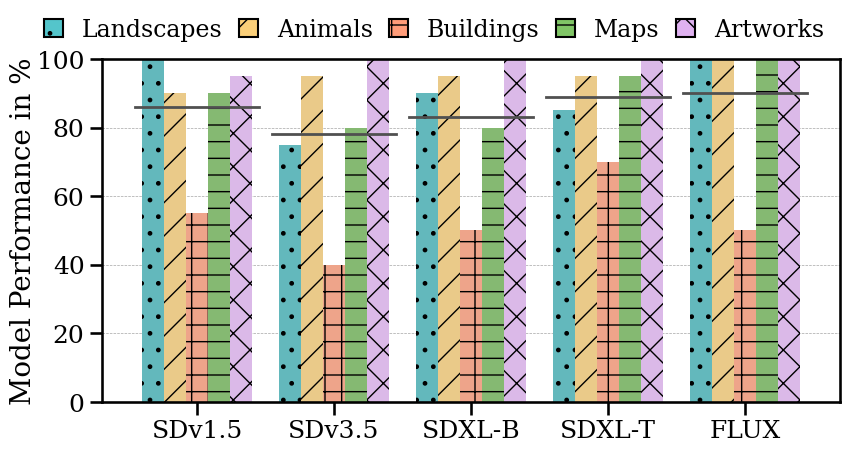

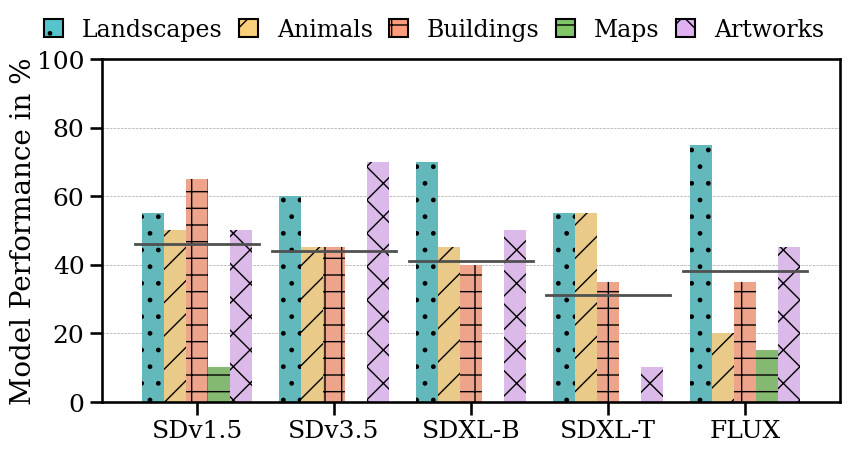

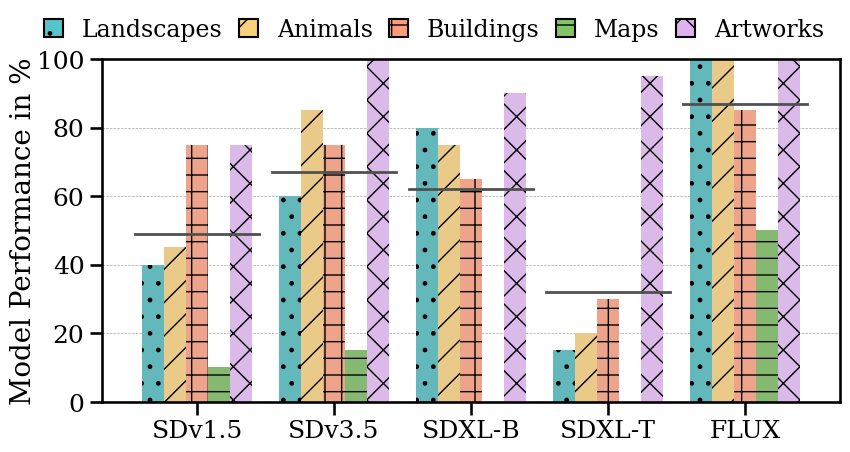

In [ ]:
colorList = ['#54C5CB', '#FACF79', '#FF9C79', "#80C566", "#DFB1F0"]

model_dict = {'sdv15': 'SDv1.5',
              'stable-diffusion-3-5': 'SDv3.5', 
              'sdxlbase': 'SDXL-B',
              'sdxlturbo': 'SDXL-T',
              'blackforest': 'FLUX'}

task_dict = {'subject_present': 'Subject Correct',
             'temporal': 'Temporal Knowledge Correct', 
             'img_correct': 'Image Quality Correct'}

category_dict = {'Time': 'Landscapes',
                 'Animals': 'Animals',
                 'Buildings': 'Buildings',
                 'Maps': 'Maps',
                 'Artworks': 'Artworks'}


for topic in ['subject_present', 'temporal', 'img_correct']:

    if isinstance(merged[f'{topic}_annot1'].iloc[0], str):
        merged[f'{topic}_annot1'] = np.where(merged[f'{topic}_annot1'].str.lower() == 'yes', 1, 0)

    group = (merged
             .groupby(['model', 'category'])[f'{topic}_annot1']
             .agg(['sum', 'count'])
             .reset_index())
    group['percentage_correct'] = (group['sum'] / group['count']) * 100
    group['category'] = group['category'].replace(category_dict)
    group['category'] = pd.Categorical(group['category'], list(category_dict.values()))
    group['model'] = group['model'].replace(model_dict)
    group['model'] = pd.Categorical(group['model'], list(model_dict.values()))
    group = group.sort_values(by=['model', 'category'])


    categories = list(category_dict.values())
    models = list(model_dict.values())
    palette = {cat: colorList[i % len(colorList)] for i, cat in enumerate(categories)}


    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(9, 5))  

    sns.barplot(
        data=group,
        x="model", y="percentage_correct",
        hue="category",
        palette=palette,
        dodge=True,
        errorbar=None,
        ax=ax
    )

    num_categories = len(group['category'].unique())
    hatches = itertools.cycle([".", "/", "+", "-", "x"])
    for i, bar in enumerate(ax.patches):
        if i % num_categories == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)


    # Calculate mean per model
    model_means = (merged
                .groupby('model')[f'{topic}_annot1']
                .agg(['sum', 'count'])
                .reset_index())
    model_means['percentage_correct'] = (model_means['sum'] / model_means['count']) * 100
    model_means['model'] = model_means['model'].replace(model_dict)


    num_categories = len(categories)
    bar_width = 0.8 / num_categories
    group_centers = np.arange(len(models))


    for idx, model in enumerate(models):
        mean_val = model_means[model_means['model'] == model]['percentage_correct'].values[0]
        x_start = idx - 0.45
        x_end = idx + 0.45
        ax.plot([x_start, x_end], [mean_val, mean_val], 
                color="#505050", linewidth=2, linestyle='-', zorder=10)


    legend_handles.append(Patch(facecolor='black', label='Model Mean'))

    ax.set_ylim(0, 100)
    ax.set_ylabel("Model Performance in %", fontsize=20, labelpad=0)
    ax.set_xlabel(None)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7, color="grey")
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    hatches = [".", "/", "+", "-", "x"]
    legend_handles = [
        Patch(facecolor=palette[c], hatch=hatches[i], edgecolor="black",  label=c)
        for i, c in enumerate(categories)
    ]
    leg = ax.legend(
        handles=legend_handles, title=None,
        loc="upper center", bbox_to_anchor=(0.45, 1.18),
        ncol=min(5, len(categories)), frameon=False,
        fontsize=17,
        handlelength=0.8,      
        handleheight=0.8,        
        columnspacing=0.7,
    )

    plt.tight_layout()
    fig.subplots_adjust(top=0.82) 
    fig.savefig(f"../img/accuracy_models_{topic}.pdf", bbox_inches="tight")
    plt.show()


# Analyze Automatic Evaluation Measures

### CLIP Score

In [ ]:
df_clip = pd.read_csv('../data/model_results/clip_scores.csv')

all_results = []

merged_clip = pd.merge(df_annot1[['model', 'prompt','subject_present',
       'img_correct', 'temporal', 'category', 'index']], df_clip, on=['prompt', 'model', 'category', 'index'], how='inner')


merged_clip['subject_present'] = merged_clip['subject_present'].map({'yes': 1, 'no': 0})
merged_clip['temporal'] = merged_clip['temporal'].map({'yes': 1, 'no': 0})
merged_clip['subject_and_temporal'] = ((merged_clip['subject_present'] == 1) & (merged_clip['temporal'] == 1)).astype(int)

# Calculate Point-biserial correlation
corr, p_value = pointbiserialr(merged_clip['subject_present'].tolist(), merged_clip['clip_score'].tolist())
all_results.append({'category': "Overall", 'pair': "subject-clip", 'pbs-corr': corr, 'p-value':p_value})

corr, p_value = pointbiserialr(merged_clip['temporal'].tolist(), merged_clip['clip_score'].tolist())
all_results.append({'category': "Overall", 'pair': "temporal-clip", 'pbs-corr': corr, 'p-value':p_value})

corr, p_value = pointbiserialr(merged_clip['subject_and_temporal'].tolist(), merged_clip['clip_score'].tolist())
all_results.append({'category': "Overall", 'pair': "subject-temp-clip", 'pbs-corr': corr, 'p-value':p_value})

for category in merged.category.unique():
    subset = merged_clip[merged_clip['category'] == category].copy()
    # Calculate Point-biserial correlation
    corr, p_value = pointbiserialr(subset['subject_present'].tolist(), subset['clip_score'].tolist())
    all_results.append({'category': category, 'pair': "subject-clip", 'pbs-corr': corr, 'p-value':p_value})

    corr, p_value = pointbiserialr(subset['temporal'].tolist(), subset['clip_score'].tolist())
    all_results.append({'category': category, 'pair': "temporal-clip", 'pbs-corr': corr, 'p-value':p_value})

    corr, p_value = pointbiserialr(subset['subject_and_temporal'].tolist(), subset['clip_score'].tolist())
    all_results.append({'category': category, 'pair': "subject-temp-clip", 'pbs-corr': corr, 'p-value':p_value})

full_df = pd.DataFrame(all_results)
print(full_df)


     category               pair  pbs-corr   p-value
0     Overall       subject-clip  0.015775  0.724929
1     Overall      temporal-clip -0.032874  0.463289
2     Overall  subject-temp-clip -0.039429  0.378969
3        Time       subject-clip -0.018470  0.855272
4        Time      temporal-clip  0.082814  0.412707
5        Time  subject-temp-clip  0.082814  0.412707
6     Animals       subject-clip  0.045420  0.653629
7     Animals      temporal-clip  0.153038  0.128485
8     Animals  subject-temp-clip  0.174044  0.083310
9    Artworks       subject-clip  0.199082  0.047065
10   Artworks      temporal-clip  0.298546  0.002553
11   Artworks  subject-temp-clip  0.298546  0.002553
12  Buildings       subject-clip -0.000392  0.996914
13  Buildings      temporal-clip  0.015217  0.880551
14  Buildings  subject-temp-clip -0.080966  0.423248
15       Maps       subject-clip  0.038747  0.701914
16       Maps      temporal-clip -0.082610  0.413866
17       Maps  subject-temp-clip -0.082610  0.

## Captioning

In [ ]:
df_captioning = pd.read_csv('../data/model_results/caption_scores.csv')

merged_captioning = pd.merge(df_annot1[['model', 'prompt','subject_present',
       'img_correct', 'temporal', 'category', 'index']], df_captioning, on=['model', 'category', 'index'], how='inner')

merged_captioning['subject_present'] = merged_captioning['subject_present'].map({'yes': 1, 'no': 0})
merged_captioning['temporal'] = merged_captioning['temporal'].map({'yes': 1, 'no': 0})
merged_captioning['subject_and_temporal'] = ((merged_captioning['subject_present'] == 1) & (merged_captioning['temporal'] == 1)).astype(int)


# Calculate Point-biserial correlation
print("Overall")
corr, p_value = pointbiserialr(merged_captioning['subject_present'].tolist(), merged_captioning['cosine'].tolist())
print(f"PBS Correlation Subject: {corr}, p-value: {p_value}")

corr, p_value = pointbiserialr(merged_captioning['temporal'].tolist(), merged_captioning['cosine'].tolist())
print(f"PBS Correlation Temporal: {corr}, p-value: {p_value}")

corr, p_value = pointbiserialr(merged_captioning['subject_and_temporal'].tolist(), merged_captioning['cosine'].tolist())
print(f"PBS Correlation Subject & Temporal: {corr}, p-value: {p_value}")
print()
for category in merged_captioning.category.unique():
    print(category)
    subset = merged_captioning[merged_captioning['category'] == category].copy()
    # Calculate Point-biserial correlation
    corr, p_value = pointbiserialr(subset['subject_present'].tolist(), subset['cosine'].tolist())
    print(f"PBS Correlation Subject: {corr}, p-value: {p_value}")

    corr, p_value = pointbiserialr(subset['temporal'].tolist(), subset['cosine'].tolist())
    print(f"PBS Correlation Temporal: {corr}, p-value: {p_value}")
    print()


Overall
PBS Correlation Subject: 0.15711236701747167, p-value: 0.0004214575826531282
PBS Correlation Temporal: -0.18404914603692327, p-value: 3.4641827346195774e-05
PBS Correlation Subject & Temporal: -0.0955272939894171, p-value: 0.03271245063567153

Time
PBS Correlation Subject: -0.21408500523438567, p-value: 0.03245206568791973
PBS Correlation Temporal: -0.0979602985236388, p-value: 0.33223518396325796

Animals
PBS Correlation Subject: -0.09223287591740877, p-value: 0.36141076772996
PBS Correlation Temporal: 0.23211662683581838, p-value: 0.020135274031311563

Artworks
PBS Correlation Subject: 0.3396867493034175, p-value: 0.0005450729736092235
PBS Correlation Temporal: 0.19103639696802927, p-value: 0.05692058917128635

Buildings
PBS Correlation Subject: 0.19478291995249258, p-value: 0.0521390672439134
PBS Correlation Temporal: -0.06928280594466622, p-value: 0.4933810284209735

Maps
PBS Correlation Subject: 0.0805379710905224, p-value: 0.4257128857644109
PBS Correlation Temporal: 0.11

## Baseline Calculation

In [ ]:
results = []
for col in ['subject_present', 'img_correct', 'temporal', 'subject_and_temporal']:
    baseline = [1] * len(df_annot1)
    
    if col == 'subject_and_temporal':
        df_annot1[col] = ((df_annot1['subject_present'] == 1) & (df_annot1['temporal'] == 1)).astype(int)
    if type(df_annot1[col][0]) == str:
        df_annot1[col] = np.where(df_annot1[col]=='yes', 1, 0)
    f1 = f1_score(df_annot1[col], baseline, zero_division=0, average="macro")
    precision = precision_score(df_annot1[col], baseline, zero_division=0, average="macro")
    recall = recall_score(df_annot1[col], baseline, zero_division=0, average="macro")
    results.append({'baseline': 'only 1',
                    'task': col,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall})
    
    baseline2 = [random.randint(0, 1) for _ in range(len(df_annot1))] 
    f1 = f1_score(df_annot1[col], baseline2, zero_division=0, average="macro")
    precision = precision_score(df_annot1[col], baseline2, zero_division=0, average="macro")
    recall = recall_score(df_annot1[col], baseline2, zero_division=0, average="macro")
    results.append({'baseline': 'random 0 1',
                    'task': col,
                        'f1': f1,
                    'precision': precision,
                        'recall': recall,})
    
    baseline3 = [0] * len(df_annot1)
    f1 = f1_score(df_annot1[col], baseline3, zero_division=0, average="macro")
    precision = precision_score(df_annot1[col], baseline3, average="macro", zero_division=0)
    recall = recall_score(df_annot1[col], baseline3, zero_division=0, average="macro")

    results.append({'baseline': 'only 0',
                    'task': col,
                        'f1': f1,
                    'precision': precision,
                        'recall': recall,})
full_res = pd.DataFrame(results)

In [25]:
full_res

,baseline,task,f1,precision,recall
0,only 1,subject_present,0.460043,0.426000,0.500000
1,random 0 1,subject_present,0.440566,0.513045,0.525853
2,only 0,subject_present,0.128920,0.074000,0.500000
3,only 1,img_correct,0.372647,0.297000,0.500000
4,random 0 1,img_correct,0.531020,0.532839,0.533935
5,only 0,img_correct,0.288762,0.203000,0.500000
6,only 1,temporal,0.285714,0.200000,0.500000
7,random 0 1,temporal,0.500944,0.512951,0.513333
8,only 0,temporal,0.375000,0.300000,0.500000
9,only 1,subject_and_temporal,0.262537,0.178000,0.500000


## Decompositional VQA results

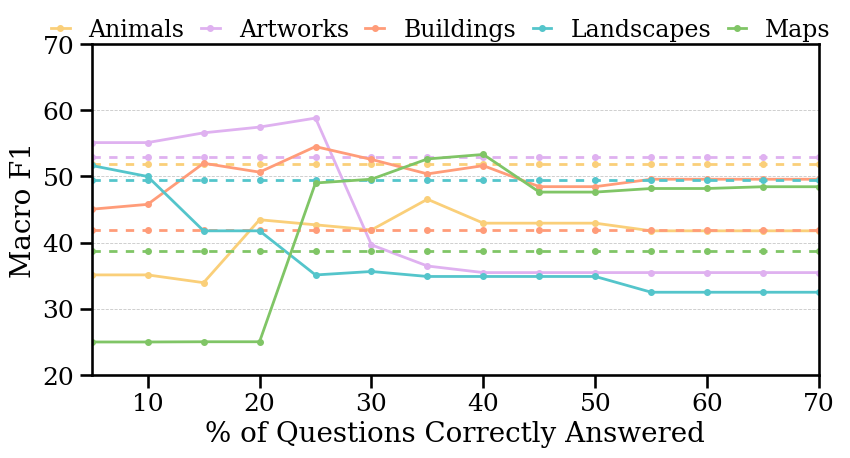

In [ ]:
df_llm = pd.read_csv('../data/model_results/decompositional_vqa.csv')
df_llm['questions'] = df_llm['questions'].apply(ast.literal_eval)
df_llm['answers'] = df_llm['answers'].apply(ast.literal_eval)

def parse_answers(row):
    true_answers = 0
    if len(row['questions']) != len(row['answers']):
        return 'wrong length'
    for i in range(len(row['questions'])):
        answer_text = row['answers'][i]
        match = re.match(r'^([A-Z])\)\s+(.*)', answer_text)
        if match:
            answer_letter = match.group(1)       
            answer_text = match.group(2)         
        else:
            answer_letter = None
        if answer_text.lower() in row[f'model_response_quest{i+1}'].lower():
            true_answers+=1
        elif (answer_letter != None):
            if (answer_letter in row[f'model_response_quest{i+1}']):
                true_answers+=1
    return true_answers

df_llm['correct_answers'] = df_llm.apply(lambda row: parse_answers(row), axis=1)
df_llm['number_questions'] = df_llm['answers'].apply(len)
df_llm['percentage_correct'] = (df_llm['correct_answers'] / df_llm['number_questions']) * 100


line_styles = {"results": "solid", "baseline": (0, (3, 3))}  

task_colors = {
    'subject_present': 'green',
    'img_correct': 'blue',
    'temporal': "#DC981A",
    'subject_and_temporal': "#DC1AA5",
}

category_colors = {
    'Animals': '#FACF79',
    'Landscapes': '#54C5CB',
    'Artworks': "#DFB1F0",
    'Maps': "#80C566",
    'Buildings': "#FF9C79",
}

merged_llm_quest = pd.merge(df_annot1[['model', 'prompt','subject_present',
       'img_correct', 'temporal', 'category', 'index']], df_llm[['model', 'category', 'index', 'percentage_correct']], on=['model', 'category', 'index'], how='inner')
for task in ['subject_present', 'img_correct', 'temporal']:
    merged_llm_quest[task] = np.where(merged_llm_quest[task]=='yes', 1, 0)
merged_llm_quest['subject_and_temporal'] = ((merged_llm_quest['subject_present'] == 1) & (merged_llm_quest['temporal'] == 1)).astype(int)
merged_llm_quest['category'] = np.where(merged_llm_quest['category'] == 'Time', 'Landscapes', merged_llm_quest['category'])


rows = []
baseline = [random.randint(0, 1) for _ in range(100)] 
for value in range(5, 100, 5):
    merged_llm_quest['final_vote'] = np.where(merged_llm_quest['percentage_correct'] < value, 0, 1)
    for category in merged_llm_quest['category'].unique():
        subset = merged_llm_quest[merged_llm_quest['category'] == category]
        # results
        f1 = f1_score(subset['subject_and_temporal'], subset['final_vote'], zero_division=0, average="macro")
        rows.append({'percentage': value, 'category': category, 'baseline': 'results', 'f1': f1})

        f1_b = f1_score(subset['subject_and_temporal'], baseline, zero_division=0, average="macro")
        rows.append({'percentage': value, 'category': category, 'baseline': 'baseline', 'f1': f1_b})

df_cat = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(9, 5))
ax = plt.gca()

for (category, bs), g in df_cat.groupby(['category','baseline']):
    g = g.sort_values('percentage')
    ax.plot(
        g['percentage'], g['f1'] * 100,
        label=(category if bs == 'results' else "_nolegend_"),
        linestyle=line_styles[bs],
        marker='o',
        linewidth=2,
        markersize=4,
        color=category_colors.get(category, None)
    )

ax.set_xlabel("% of Questions Correctly Answered", fontsize=20)
ax.set_ylabel("Macro F1", fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim(20, 70)
ax.set_xlim(5, 70)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.7)
ax.legend(
    loc="upper center", bbox_to_anchor=(0.48, 1.14),
    ncol=5, frameon=False,
    fontsize=17,
    handlelength=0.8,    
    handleheight=0.8,   
    columnspacing=0.7,
)


plt.tight_layout()
plt.show()
fig.savefig(f"../img/decompositional_vqa.pdf", bbox_inches="tight")

## Direct VLM Judging

In [27]:
row_names = {
    'subject_present': 'Subject',
    'img_correct': 'Quality',
    'temporal': 'Temporal',
    'subject_and_temporal': 'Subj+Temp',
}

def parse_model_answers(row, col_name):
    if type(row[col_name]) == str:
        answer_string = row[col_name].lower().replace('assistant\n', '').replace('\n',' ')
        if 'yes' in answer_string:
            return 1
        elif 'no' in answer_string:
            return 0
        else:
            return -1
    else:
        return -1
        


### Simple

In [72]:
vlm_cols = ['model_response_annotation_prompt_2','model_response_annotation_prompt_2']

results = []
for file in glob.glob(f'../data/model_results/vlm_judging_*simple.csv'):
    file_name = file.split('/')[-1][:-4].replace('vlm_judging_', '')
    print(file_name)
    df = pd.read_csv(file)

    for col in vlm_cols:
        df[f'{col}_parsed'] = df.apply(lambda row: parse_model_answers(row, col), axis=1)


    # Merge on multiple keys: id and date
    merged_vls = pd.merge(df_annot1[['model', 'prompt','subject_present',
        'img_correct', 'temporal', 'category', 'index']], df, on=['model',  'category', 'index'], how='inner')

    
    for human_anno, vlm_anno in zip(['temporal', 'subject_and_temporal'], [x +'_parsed' for x in vlm_cols]):

        if human_anno != 'subject_and_temporal':
            if type(merged_vls[human_anno][0]) == str:
                merged_vls[human_anno] = np.where(merged_vls[human_anno]=='yes', 1, 0)
            merged_vls = merged_vls[merged_vls[vlm_anno] >=0]
        else: 
            merged_vls['subject_present'] = np.where(merged_vls['subject_present']=='yes', 1, 0)
            merged_vls[human_anno] = ((merged_vls['subject_present'] == 1) & (merged_vls['temporal'] == 1)).astype(int)

        
        accuracy = accuracy_score(merged_vls[human_anno], merged_vls[vlm_anno])
        precision = precision_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        recall = recall_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        f1 = f1_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        tn, fp, fn, tp = confusion_matrix(merged_vls[human_anno], merged_vls[vlm_anno], labels=[0, 1]).ravel()

        results.append({'strategy': file_name, 
                        'task':row_names[human_anno],  
                        'precision': precision, 
                        'recall': recall,
                        'f1': f1, 
                        })
        

    

    corr_df = pd.DataFrame(results)
print(corr_df[corr_df['task'] == 'Subj+Temp'])



qwen_32b_0_shot_simple
gpt-4o-mini_0_shot_simple
gpt-5_3_shot_simple
gpt-4o-mini_3_shot_simple
qwen_32b_3_shot_simple
gpt-5_0_shot_simple
                     strategy       task  precision  recall     f1
1      qwen_32b_0_shot_simple  Subj+Temp     0.6430  0.6005 0.5998
3   gpt-4o-mini_0_shot_simple  Subj+Temp     0.6443  0.6121 0.6146
5         gpt-5_3_shot_simple  Subj+Temp     0.7566  0.7087 0.7201
7   gpt-4o-mini_3_shot_simple  Subj+Temp     0.6271  0.6173 0.6201
9      qwen_32b_3_shot_simple  Subj+Temp     0.6193  0.6272 0.6199
11        gpt-5_0_shot_simple  Subj+Temp     0.7315  0.6603 0.6679


### Instruction

In [90]:

rating_map = {
    "outstanding": 1,
    "very good": 1,
    "good": 1,
    "fair": 0,
    "poor": 0,
    "very poor": 0,
    "extremely poor": 0,
}

def get_rating(row, col):
    parts = row[col].split('\n\n')
    if len(parts) > 1:
        for part in parts: 
            if 'RATING' in part:
                rating = part.replace('*', '').replace('#', '').replace('\n', '').replace('RATING:', '').strip()
                return rating_map[rating.lower()]


col = 'model_response_vlm_prompt'

results = []
for file in glob.glob(f'../data/model_results/vlm_judging_qwen*instruct.csv'):
    file_name = file.split('/')[-1][:-4].replace('vlm_judging_', '')
    print(file_name)
    df = pd.read_csv(file)

    df[f'{col}_parsed'] = df.apply(lambda row: get_rating(row, col), axis=1)
    

    # Merge on multiple keys: id and date
    merged_vls = pd.merge(df_annot1[['model', 'prompt','subject_present',
        'img_correct', 'temporal', 'category', 'index']], df, on=['model',  'category', 'index'], how='inner')
    for anno in ['subject_present', 'temporal']:
        if type(merged_vls[anno][0]) == str:
                merged_vls[anno] = np.where(merged_vls[anno]=='yes', 1, 0)
    merged_vls['subject_and_temporal'] = ((merged_vls['subject_present'] == 1) & (merged_vls['temporal'] == 1)).astype(int)
    
    
    for human_anno, vlm_anno in zip(['subject_and_temporal'], [f'{col}_parsed']):

        precision = precision_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        recall = recall_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        f1 = f1_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        results.append({'strategy': file_name, 
                        'task':row_names[human_anno],  
                        'precision': precision, 
                        'recall': recall,
                        'f1': f1, 
                        })


corr_df = pd.DataFrame(results)
print(corr_df)

qwen_32b_0_shot_instruct
qwen_32b_3_shot_instruct
                   strategy       task  precision  recall     f1
0  qwen_32b_0_shot_instruct  Subj+Temp     0.6484  0.6435 0.6455
1  qwen_32b_3_shot_instruct  Subj+Temp     0.6590  0.6722 0.6582


In [92]:

rating_map = {
    "outstanding": 1,
    "very good": 1,
    "good": 1,
    "fair": 0,
    "poor": 0,
    "very poor": 0,
    "extremely poor": 0,
}


col = 'model_response_vlm_prompt'

results = []
for file in glob.glob(f'../data/model_results/vlm_judging_gpt*instruct.csv'):
    file_name = file.split('/')[-1][:-4].replace('vlm_judging_', '')
    print(file_name)
    df = pd.read_csv(file)


    df[f'{col}_parsed'] = df[col]\
                        .str.lower()\
                        .str.extract(r'rating(.{,25})$')[0]\
                        .str.replace(':', '')\
                        .str.strip()
    df[f'{col}_parsed'] = df[f'{col}_parsed'].map(rating_map)


    # Merge on multiple keys: id and date
    merged_vls = pd.merge(df_annot1[['model', 'prompt','subject_present',
        'img_correct', 'temporal', 'category', 'index']], df, on=['model',  'category', 'index'], how='inner')
    for anno in ['subject_present', 'temporal']:
        if type(merged_vls[anno][0]) == str:
                merged_vls[anno] = np.where(merged_vls[anno]=='yes', 1, 0)
    merged_vls['subject_and_temporal'] = ((merged_vls['subject_present'] == 1) & (merged_vls['temporal'] == 1)).astype(int)
    
    
    for human_anno, vlm_anno in zip(['subject_and_temporal'], [f'{col}_parsed']):

        precision = precision_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        recall = recall_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        f1 = f1_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
        results.append({'strategy': file_name, 
                        'task':row_names[human_anno],  
                        'precision': precision, 
                        'recall': recall,
                        'f1': f1, 
                        })


corr_df = pd.DataFrame(results)
print(corr_df)

gpt-4o-mini_3_shot_instruct
gpt-4o-mini_0_shot_instruct


gpt-5_3_shot_instruct
                      strategy       task  precision  recall     f1
0  gpt-4o-mini_3_shot_instruct  Subj+Temp     0.5933  0.5798 0.5807
1  gpt-4o-mini_0_shot_instruct  Subj+Temp     0.6095  0.5954 0.5975
2        gpt-5_3_shot_instruct  Subj+Temp     0.7461  0.6947 0.7054


## Error Analysis

vlm_judging_gpt-5_3_shot_simple
500
  category       task  precision  recall     f1
0  overall  Subj+Temp     0.7566  0.7087 0.7201


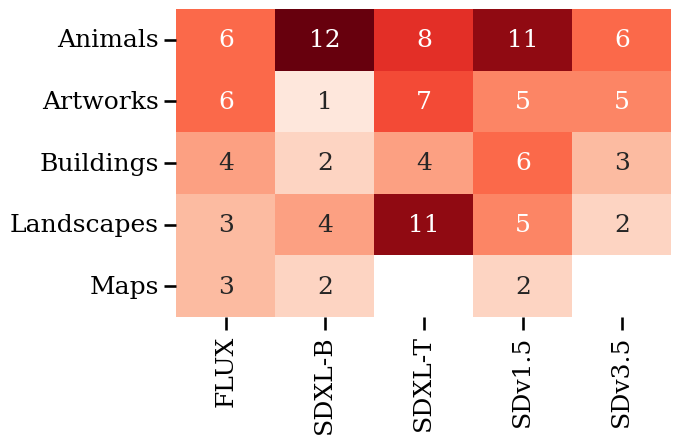

In [53]:
file = '../data/model_results/vlm_judging_gpt-5_3_shot_simple.csv'


def parse_model_answers(row, col_name):
    if type(row[col_name]) == str:
        answer_string = row[col_name].lower().replace('assistant\n', '').replace('\n',' ')
        if 'yes' in answer_string:
            return 1
        elif 'no' in answer_string:
            return 0
        else:
            return -1
    else:
        return -1

file_name = file.split('/')[-1][:-4]
print(file_name)
df = pd.read_csv(file)


df[f'model_response_annotation_prompt_2_parsed'] = df.apply(lambda row: parse_model_answers(row, 'model_response_annotation_prompt_2'), axis=1)


# Merge on multiple keys: id and date
merged_vls = pd.merge(df_annot1[['model', 'prompt','subject_present',
    'img_correct', 'temporal', 'category', 'index']], df, on=['model',  'category', 'index'], how='inner')

for anno in ['subject_present', 'temporal']:
    merged_vls[anno] = np.where(merged_vls[anno]=='yes', 1, 0)
merged_vls['subject_and_temporal'] = ((merged_vls['subject_present'] == 1) & (merged_vls['temporal'] == 1)).astype(int)

results = []
for human_anno, vlm_anno in zip(['subject_and_temporal'], ['model_response_annotation_prompt_2_parsed']):

    precision = precision_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
    recall = recall_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
    f1 = f1_score(merged_vls[human_anno], merged_vls[vlm_anno], zero_division=0, average="macro")
    print(len(merged_vls[human_anno]))
    results.append({'category': 'overall', 
                    'task':row_names[human_anno],  
                    'precision': precision, 
                    'recall': recall,
                    'f1': f1, 
                    })



corr_df = pd.DataFrame(results)
print(corr_df)

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "STIXGeneral"],
    "pdf.fonttype": 42, "ps.fonttype": 42, "svg.fonttype": "none",
})

model_dict = {'sdv15': 'SDv1.5',
              'stable-diffusion-3-5': 'SDv3.5', 
              'sdxlbase': 'SDXL-B',
              'sdxlturbo': 'SDXL-T',
              'blackforest': 'FLUX', }

error_subset = merged_vls[merged_vls['subject_and_temporal'] != merged_vls['model_response_annotation_prompt_2_parsed']].copy()


err = error_subset.groupby(["model", "category"])['prompt_x'].count().reset_index()
err['model'] = err['model'].map(model_dict)
err['category'] = np.where(err['category'] == 'Time', 'Landscapes', err['category'])
pivot = err.pivot(index="category", columns="model", values="prompt_x")  


fig, ax = plt.subplots(figsize=(5.5, 4), dpi=100)
ax = sns.heatmap(
    pivot,
    vmin=0, vmax=12, cmap="Reds",
    annot=True, 
    annot_kws={"fontsize":18},
   cbar=False,
)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)


ax.set_xlabel("")
ax.set_ylabel("")

fig.subplots_adjust(left=0.0)
plt.show()
fig.savefig(f"../img/error_analysis.pdf", bbox_inches="tight")

vlm_judging_gpt-5_3_shot_simple


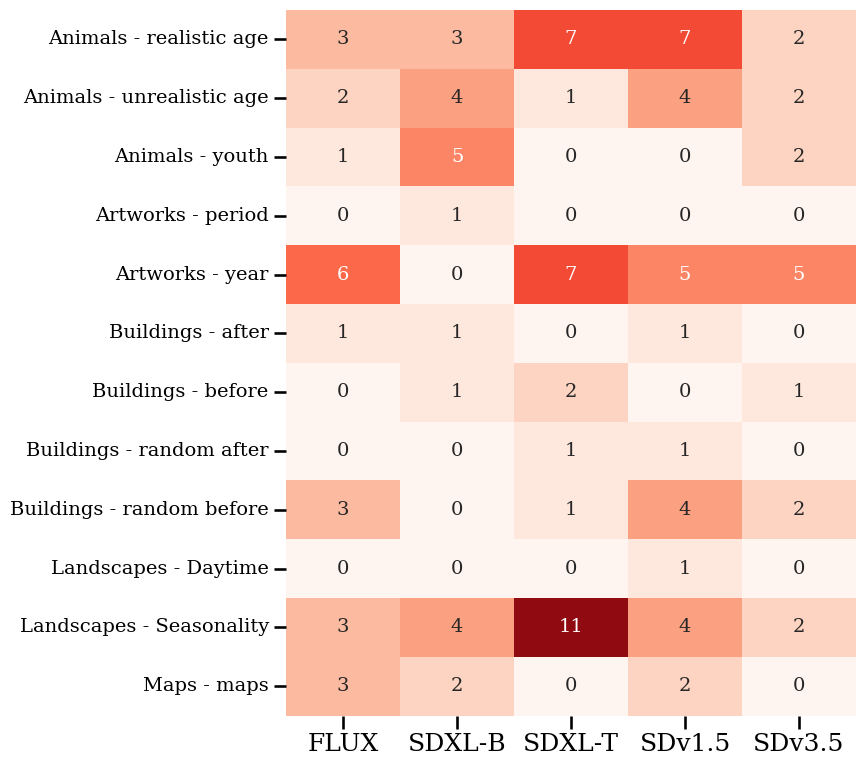

In [59]:
file = '../data/model_results/vlm_judging_gpt-5_3_shot_simple.csv'



file_name = file.split('/')[-1][:-4]
print(file_name)
df = pd.read_csv(file)


df[f'model_response_annotation_prompt_2_parsed'] = df.apply(lambda row: parse_model_answers(row, 'model_response_annotation_prompt_2'), axis=1)


# Merge on multiple keys: id and date
merged_vls = pd.merge(df_annot1[['model', 'prompt','subject_present', 'promptcategory',
    'img_correct', 'temporal', 'category', 'index', 'temporalvalue']], df[['model', 'prompt', 'category', 'index', 'model_response_annotation_prompt_2_parsed']], on=['model',  'category', 'index'], how='inner')

for anno in ['subject_present', 'temporal']:
    merged_vls[anno] = np.where(merged_vls[anno]=='yes', 1, 0)
merged_vls['subject_and_temporal'] = ((merged_vls['subject_present'] == 1) & (merged_vls['temporal'] == 1)).astype(int)




model_dict = {'sdv15': 'SDv1.5',
              'stable-diffusion-3-5': 'SDv3.5', 
              'sdxlbase': 'SDXL-B',
              'sdxlturbo': 'SDXL-T',
              'blackforest': 'FLUX', }

error_subset = merged_vls[merged_vls['subject_and_temporal'] != merged_vls['model_response_annotation_prompt_2_parsed']].copy()


# Group by both category and promptcategory
err = error_subset.groupby(["model", "category", "promptcategory"])['prompt_x'].count().reset_index()
err['model'] = err['model'].map(model_dict)

# Create pivot with multi-level index
pivot = err.pivot_table(
    index=["category", "promptcategory"], 
    columns="model", 
    values="prompt_x",
    fill_value=0
)

fig, ax = plt.subplots(figsize=(9, 8), dpi=100)
ax = sns.heatmap(
    pivot,
    vmin=0, vmax=12, cmap="Reds",
    annot=True, 
    annot_kws={"fontsize":14},
    cbar=False,
    yticklabels=[f"{cat} - {subcat}" for cat, subcat in pivot.index]
)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.show()
fig.savefig(f"../img/error_analysis_for_temporal_cues.pdf", bbox_inches="tight")